In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.optim as optim

In [3]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "data3/data3", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(200,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


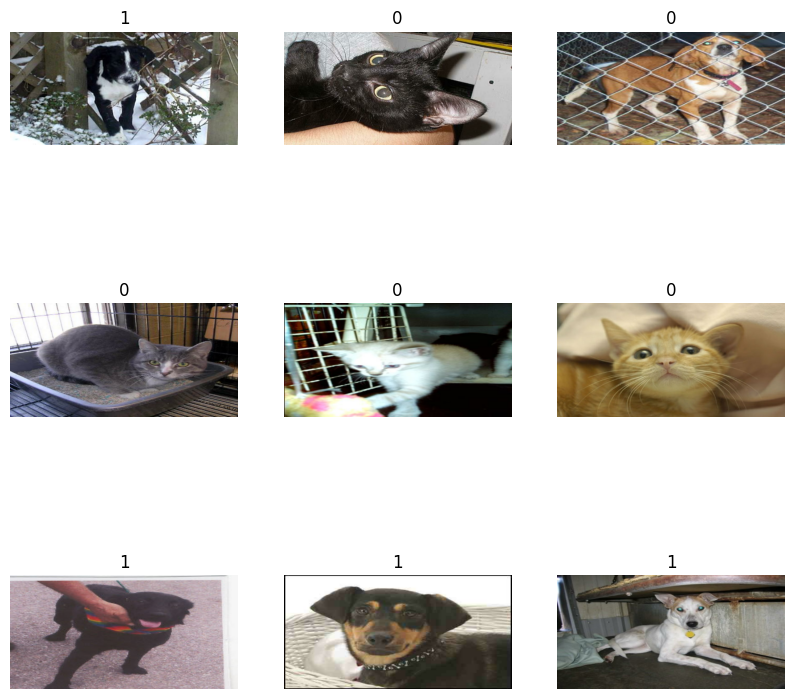

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [5]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

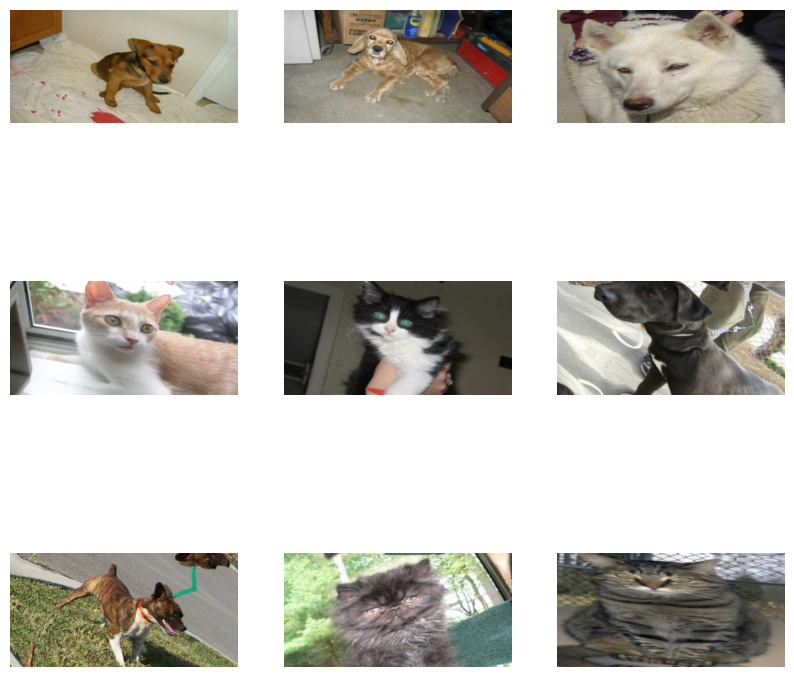

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
# выполним аугментации для обучающих данных предварительно (1 способ)
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

In [8]:
# входной слой - размер (200, 400, 3)
inputs = tf.keras.Input(shape=(200, 400, 3))
# преобразуем значения пикселей из [0, 255] к [0, 1]
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
# первый сверточный слой
x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same")(x)
# первый пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# второй сверточный слой
x = tf.keras.layers.Conv2D(128, 4, strides=2, padding="same")(x)
# второй пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# выпрямляем многомерный массив
x = tf.keras.layers.Flatten()(x)
# полносвязный слой с 64 нейронами
x = tf.keras.layers.Dense(64, activation="relu")(x)
# выходной слой с функцией sofrmax
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 400, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 200, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 100, 64)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 50, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 25, 128)       0         
 g2D)                                                        

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [11]:
model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5


50/50 [==============================] - 51s 938ms/step - loss: 1.3790 - accuracy: 0.4981 - val_loss: 0.6879 - val_accuracy: 0.5375
Epoch 2/5
50/50 [==============================] - 47s 933ms/step - loss: 0.6866 - accuracy: 0.5575 - val_loss: 0.6528 - val_accuracy: 0.6125
Epoch 3/5
50/50 [==============================] - 47s 931ms/step - loss: 0.7057 - accuracy: 0.5362 - val_loss: 0.6905 - val_accuracy: 0.5350
Epoch 4/5
50/50 [==============================] - 44s 870ms/step - loss: 0.6851 - accuracy: 0.5606 - val_loss: 0.6857 - val_accuracy: 0.6350
Epoch 5/5
50/50 [==============================] - 40s 791ms/step - loss: 0.6926 - accuracy: 0.4938 - val_loss: 0.6919 - val_accuracy: 0.5500


In [12]:
predictions = [np.argmax(pred) for pred in model.predict(test_ds)]

13/13 [==============================] - 1s 100ms/step


In [15]:
import numpy as np
y_test = []
imag=[]
j=0
for images,lab in test_ds.take(16):
    for i in lab:
        y_test.append(int(i))    
for images,lab in test_ds.take(16):
    for i in images:
        imag.append(np.asarray(i))

In [16]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       182
           1       0.55      1.00      0.71       218

    accuracy                           0.55       400
   macro avg       0.77      0.51      0.36       400
weighted avg       0.75      0.55      0.40       400



In [17]:
import numpy as np

class MLP:
    def __init__(self, layer_sizes, activation_functions):
        self.num_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.activation_functions = activation_functions
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i-1]) for i in range(1, self.num_layers)]
        self.biases = [np.random.randn(layer_sizes[i], 1) for i in range(1, self.num_layers)]

    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def _sigmoid_derivative(self, x):
        return self._sigmoid(x) * (1 - self._sigmoid(x))

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def _feed_forward(self, x):
        # х-ый элеменет
        activations = [x]
        zs = []
        for i in range(self.num_layers - 1):
            weight = self.weights[i]
            bias = self.biases[i]
            activation_fn = self.activation_functions[i]
            #умножаем матрицу весов на вектор активаций последнего слоя + вектор смещения
            z = np.dot(weight, activations[-1]) + bias
            zs.append(z)
            if activation_fn == 'sigmoid':
                a = self._sigmoid(z)
            elif activation_fn == 'tanh':
                a = self._tanh(z)
            elif activation_fn == 'relu':
                a = self._relu(z)
            activations.append(a)
        return activations, zs

    def _backpropagate(self, x, y):
        # накопление градиентов функции потерь по весам и смещениям в каждом слое сети
        delta_weights = [np.zeros(weight.shape) for weight in self.weights]
        delta_biases = [np.zeros(bias.shape) for bias in self.biases]
        # прямой проход сети для входных данных x, и сохраняются активации и взвешенные суммы для каждого слоя 
        activations, zs = self._feed_forward(x)
        #разница между предсказанными активациями и фактическими значениями целевой переменной
        delta = (activations[-1] - y) 
        for i in range(self.num_layers - 2, -1, -1):
            # Получение взвешенной суммы
            z = zs[i]
            activation_fn = self.activation_functions[i]
            if activation_fn == 'sigmoid':
                derivative = self._sigmoid_derivative(z)
            elif activation_fn == 'tanh':
                derivative = self._tanh_derivative(z)
            elif activation_fn == 'relu':
                derivative = self._relu_derivative(z)
            #Вычисление градиента по весам для текущего слоя
            delta_weights[i] = np.dot(delta, activations[i].T)
            delta_biases[i] = delta
            delta = np.dot(self.weights[i].T, delta) * derivative
        return delta_weights, delta_biases

    def fit(self, X_train, y_train, learning_rate, num_epochs):
        for epoch in range(num_epochs):
            for x, y in zip(X_train, y_train):
                x = np.array(x, ndmin=2).T
                y = np.array(y, ndmin=2).T
                delta_weights, delta_biases = self._backpropagate(x, y)
                self.weights = [weight - learning_rate * d_weight for weight, d_weight in zip(self.weights, delta_weights)]
                self.biases = [bias - learning_rate * d_bias for bias, d_bias in zip(self.biases, delta_biases)]

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            # массив минимум 2мерный и транспонируем
            x = np.array(x, ndmin=2).T
            activations, _ = self._feed_forward(x)
            predictions.append(activations[-1])
        return predictions

In [18]:
class ConvolutionalLayer:
    def __init__(self, input_channels, output_channels, kernel_size, activation_function):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.activation_function = activation_function

        # Инициализация весов сверточного слоя
        self.kernels = np.random.randn(output_channels, input_channels, kernel_size, kernel_size)
        self.biases = np.zeros((output_channels, 1))

        # Инициализация MLP для обработки выходных данных сверточного слоя
        self.mlp = MLP(layer_sizes=[output_channels * (input_channels - kernel_size + 1) * (input_channels - kernel_size + 1), 2],
                       activation_functions=[activation_function])

    def _convolve(self, input_data):
        batch_size, input_height, input_width = input_data.shape
        output_height = input_height - self.kernel_size + 1
        output_width = input_width - self.kernel_size + 1

        # Применение сверточных ядер
        conv_output = np.zeros((self.output_channels, output_height, output_width))
        for i in range(output_height):
            for j in range(output_width):
                input_slice = input_data[:, i:i+self.kernel_size, j:j+self.kernel_size]
                conv_output[:, i, j] = np.sum(input_slice * self.kernels, axis=(1, 2, 3)) + self.biases.flatten()

        # Решейпим для подачи в MLP
        return conv_output.reshape(batch_size, -1)

    def forward(self, input_data):
        conv_output = self._convolve(input_data)
        mlp_output = self.mlp.predict(conv_output)
        return mlp_output

    def backward(self, input_data, target, learning_rate):
        batch_size, input_height, input_width = input_data.shape

        # Прямой проход
        conv_output = self._convolve(input_data)
        mlp_output = self.mlp.predict(conv_output)

        # Вычисление градиента для MLP
        mlp_delta = mlp_output - target
        mlp_delta_weights, mlp_delta_biases = self.mlp._backpropagate(conv_output, target)

        # Обновление весов MLP
        self.mlp.weights = [weight - learning_rate * d_weight for weight, d_weight in zip(self.mlp.weights, mlp_delta_weights)]
        self.mlp.biases = [bias - learning_rate * d_bias for bias, d_bias in zip(self.mlp.biases, mlp_delta_biases)]

        # Вычисление градиента для сверточного слоя
        conv_delta = np.dot(self.mlp.weights[0].T, mlp_delta.T).T
        conv_delta = conv_delta.reshape(batch_size, self.output_channels, input_height - self.kernel_size + 1, input_width - self.kernel_size + 1)

        # Обновление весов сверточного слоя
        for i in range(self.output_channels):
            for j in range(self.kernel_size):
                for k in range(self.kernel_size):
                    self.kernels[i, :, j, k] -= learning_rate * np.sum(input_data[:, j:j + input_height - self.kernel_size + 1, k:k + input_width - self.kernel_size + 1] * conv_delta[:, i, :, :])
            self.biases[i] -= learning_rate * np.sum(conv_delta[:, i, :, :])

In [19]:
class SimpleCNN:
    def __init__(self):
        self.conv1 = ConvolutionalLayer(3, 2, 3, 'sigmoid')
        self.conv2 = ConvolutionalLayer(5, 10, 3, 'sigmoid')

    def forward(self, input_data):
        x = self.conv1.forward(input_data)
        x = self.conv2.forward(x)
        return x

    def backward(self, delta):
        delta = self.conv2.backward(delta)
        delta = self.conv1.backward(delta)
        return delta

    def update(self, learning_rate):
        self.conv1.update(learning_rate)
        self.conv2.update(learning_rate)

In [20]:
# Обучение модели
cnn_model = SimpleCNN()
num_epochs = 5
for epoch in range(num_epochs):
    
    conv_output = cnn_model.forward(train_ds)
    delta = np.random.randn(*conv_output.shape)
    loss = criterion(conv_output.view(-1, 2), labels) 
        
    cnn_model.backward(delta)
    cnn_model.update(0.01)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

print('Обучение завершено!')

AttributeError: '_MapDataset' object has no attribute 'shape'

## Задание 2

### VGG19

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.optim as optim

In [9]:
# формируем датасет
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "101_ObjectCategories", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(224,224), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 897 files belonging to 3 classes.
Using 763 files for training.
Using 134 files for validation.


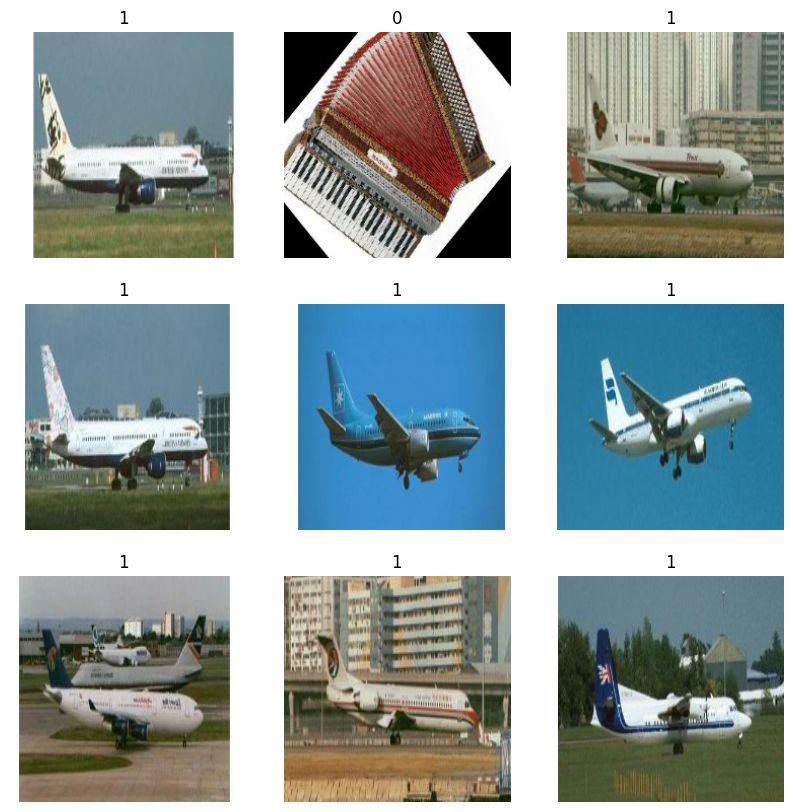

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [12]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

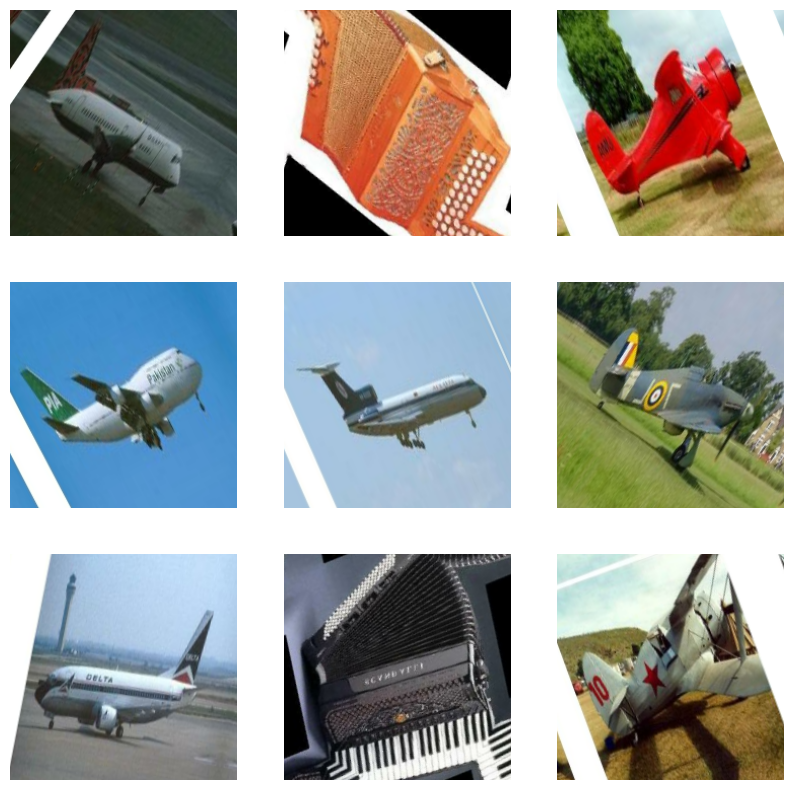

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [14]:
# выполним аугментации для обучающих данных предварительно (1 способ)
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

In [15]:
# загружаем предварительно обученную сеть VGG19
# параметр include_top со значением true указывает, что вместе со сверточными будут загружены
# полносвязные слои
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=True)
vgg.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0    

In [16]:
# сохраним ссылку на входной слой сети
inp = vgg.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой VGG и наш новый слой классификации
out = new_classification_layer(vgg.layers[-2].output)

# создадим новую модель
model_new = tf.keras.Model(inp, out)

In [17]:
# посмотрим, что изменилось
model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
# "заморозим" все слои, кроме последнего
for layer in model_new.layers:
    layer.trainable = False
model_new.layers[-1].trainable = True
model_new.layers[-3].trainable = True

In [19]:
model_new.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0    

In [20]:
model_new.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5


24/24 [==============================] - 238s 10s/step - loss: 0.3024 - accuracy: 0.9423 - val_loss: 7.7823e-04 - val_accuracy: 1.0000
Epoch 2/5
24/24 [==============================] - 221s 9s/step - loss: 0.0223 - accuracy: 0.9948 - val_loss: 0.0521 - val_accuracy: 0.9925
Epoch 3/5
24/24 [==============================] - 222s 9s/step - loss: 3.1945e-05 - accuracy: 1.0000 - val_loss: 1.7284e-05 - val_accuracy: 1.0000
Epoch 4/5
24/24 [==============================] - 220s 9s/step - loss: 0.0212 - accuracy: 0.9934 - val_loss: 0.1954 - val_accuracy: 0.9701
Epoch 5/5
24/24 [==============================] - 225s 9s/step - loss: 0.0059 - accuracy: 0.9974 - val_loss: 0.0038 - val_accuracy: 1.0000


In [21]:
predictions = [np.argmax(pred) for pred in model_new.predict(test_ds)]

5/5 [==============================] - 31s 6s/step


In [22]:
y_test = []
j=0
for images,lab in test_ds.take(16):
    for i in lab:
        y_test.append(int(i))  

In [23]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00       118
           2       1.00      1.00      1.00         7

    accuracy                           1.00       134
   macro avg       1.00      1.00      1.00       134
weighted avg       1.00      1.00      1.00       134



### InceptionV3

In [24]:
# формируем датасет
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "101_ObjectCategories", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(224,224), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 897 files belonging to 3 classes.
Using 763 files for training.
Using 134 files for validation.


In [25]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

In [26]:
# выполним аугментации для обучающих данных предварительно (1 способ)
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)


In [27]:
inv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=True)
inv3.summary()

96112376/96112376 [==============================] - 14s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activati

In [28]:
# сохраним ссылку на входной слой сети
inp = inv3.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой VGG и наш новый слой классификации
out = new_classification_layer(inv3.layers[-2].output)

# создадим новую модель
model_new2 = tf.keras.Model(inp, out)

In [29]:
# посмотрим, что изменилось
model_new2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0]

In [30]:
# "заморозим" все слои, кроме последнего
for layer in model_new2.layers:
    layer.trainable = False
model_new2.layers[-1].trainable = True
model_new2.layers[-3].trainable = True

In [31]:
model_new2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0]

In [32]:
model_1.reshape
model_new2.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5


ValueError: in user code:

    File "D:\environment\venv\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "D:\environment\venv\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\environment\venv\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "D:\environment\venv\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "D:\environment\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\environment\venv\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(None, 224, 224, 3)


In [33]:
predictions = [np.argmax(pred) for pred in model_new2.predict(test_ds)]

ValueError: in user code:

    File "D:\environment\venv\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "D:\environment\venv\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\environment\venv\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "D:\environment\venv\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "D:\environment\venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\environment\venv\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(None, 224, 224, 3)


In [34]:
y_test = []
j=0
for images,lab in test_ds.take(16):
    for i in lab:
        y_test.append(int(i))  

In [35]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00       118
           2       1.00      1.00      1.00         7

    accuracy                           1.00       134
   macro avg       1.00      1.00      1.00       134
weighted avg       1.00      1.00      1.00       134

